# Members
- Hilmi Zharfan Rachmadi - 5025201268
- Fadel Pramaputra Maulana - 	5025201260
- Vania Rizky Juliana Wachid - 	5025201215

# Used Datasets
- Google_Stock_Price_Train.csv -> Training and Validation
- Google_Stock_Price_Test.csv -> Testing

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Importing Libraries 

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
import keras
from keras import layers
from keras.optimizers import RMSprop
from keras.models import Sequential
# from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LeakyReLU
from keras.layers import Dense, Dropout, LSTM

!pip install -U scikit-learn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading Dataset

In [ ]:
def load_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Converting Date to datetime
    data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y")

    # Converting Close to numeric
    data['Close'] = data['Close'].replace('[^\d.]', '', regex=True)
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

    # Converting Volume to numeric
    data['Volume'] = data['Volume'].replace('[^\d.]', '', regex=True)
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    return data

In [ ]:
data = load_data('/content/Google_Stock_Price_Train.csv')

# Show the first 5 rows of dataset
data.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500
1,2012-01-04,331.27,333.87,329.08,666.45,5749400
2,2012-01-05,329.83,330.75,326.89,657.21,6590300
3,2012-01-06,328.34,328.77,323.68,648.24,5405900
4,2012-01-09,322.04,322.29,309.46,620.76,11688800


# Preprocessing

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1258.0,5.337098e+02,1.519044e+02,279.12,404.115,537.470,6.549225e+02,816.68
High,1258.0,5.378802e+02,1.530088e+02,281.21,406.765,540.750,6.625875e+02,816.68
Low,1258.0,5.290074e+02,1.505528e+02,277.22,401.765,532.990,6.448000e+02,805.14
Close,1258.0,7.126697e+02,1.647526e+02,491.20,576.740,695.675,7.821050e+02,1216.83
Volume,1258.0,3.158107e+06,2.273726e+06,7900.00,1621700.000,2566150.000,4.122500e+06,24977900.00


In [ ]:
data_copy = data.copy(deep = True)

print(data_copy.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


There seems to be no null value in the dataset

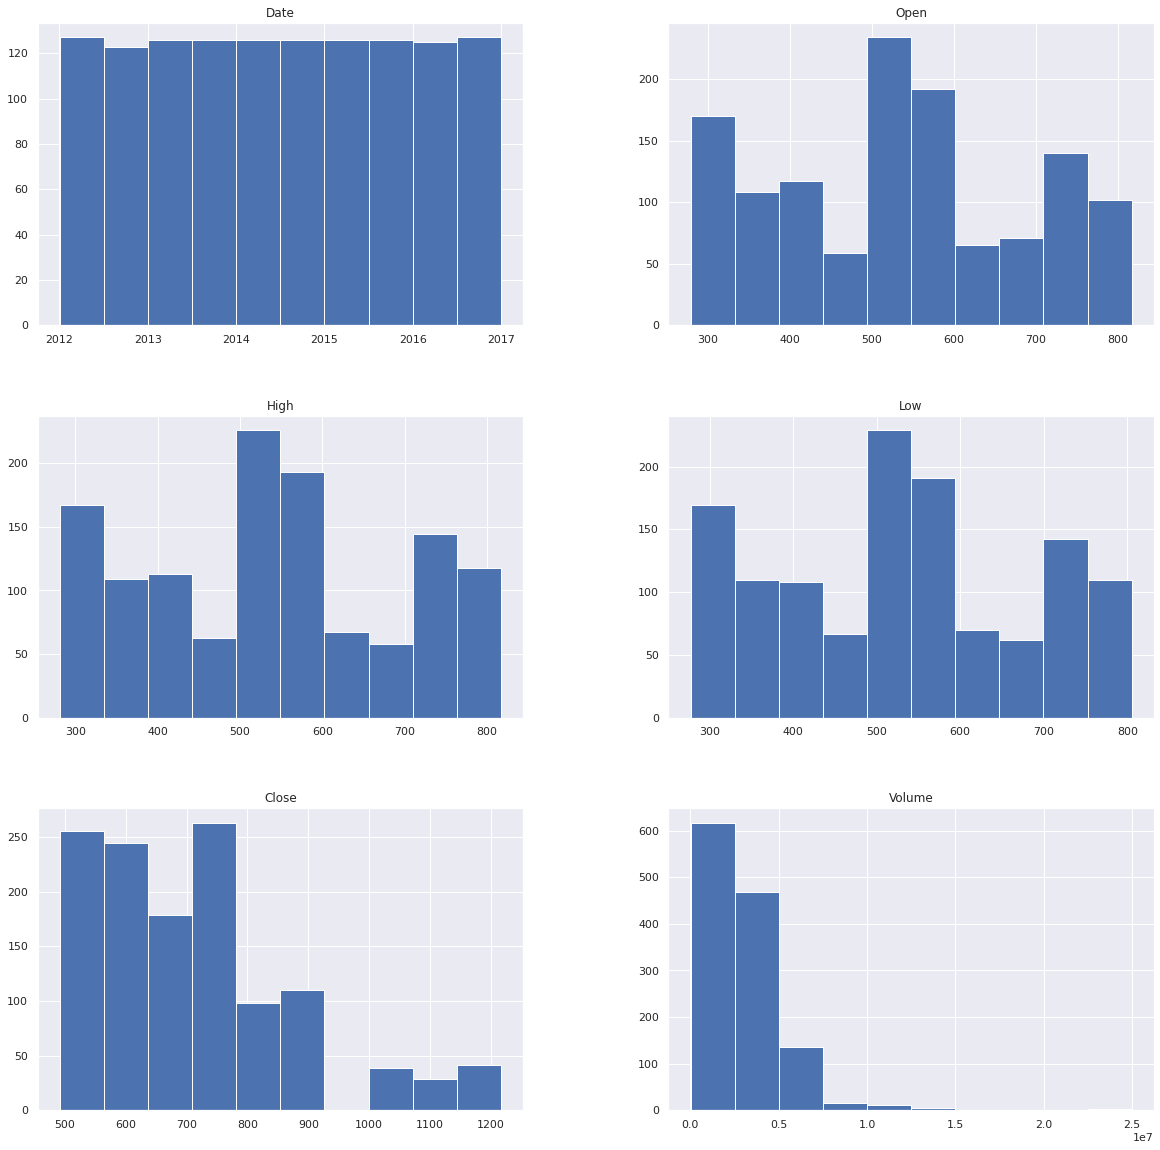

In [ ]:
h = data.hist(figsize = (20,20))

# Checking for Outliers
The presence of outliers is examined using the Interquartile Range (IQR) method. Data points that fall outside the range of the first quartile to the third quartile are considered outliers.

In [ ]:
# Using IQR
import numpy as np

def get_lower_upper_bound(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    lower_bound = q1-(iqr*1.5)
    upper_bound = q3+(iqr*1.5)
    return lower_bound, upper_bound

def get_outliers_iqr(x):
    lower_bound, upper_bound = get_lower_upper_bound(x)
    return x[np.where((x > upper_bound) | (x < lower_bound))]

In [ ]:
def count_outliers(df, col):
    arr = get_outliers_iqr(df[col].values) 
    display(arr)   
    np.count_nonzero(arr)
    display(arr.size)

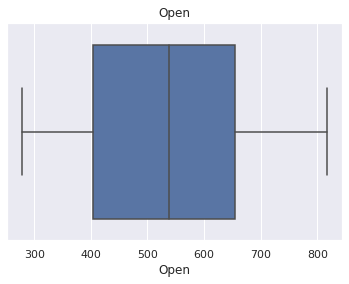

Number of outliers in Open:


array([], dtype=float64)

0

None


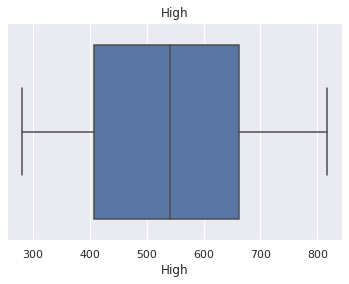

Number of outliers in High:


array([], dtype=float64)

0

None


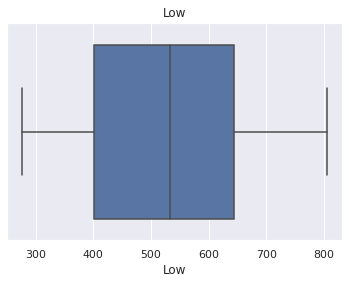

Number of outliers in Low:


array([], dtype=float64)

0

None


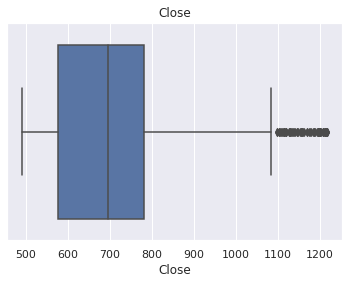

Number of outliers in Close:


array([1097.61, 1112.05, 1108.8 , 1114.4 , 1115.34, 1106.42, 1117.64,
       1110.07, 1101.97, 1114.26, 1135.74, 1138.11, 1127.15, 1127.09,
       1119.91, 1146.25, 1145.48, 1153.05, 1147.38, 1160.51, 1161.83,
       1156.92, 1120.75, 1098.21, 1119.94, 1103.89, 1132.28, 1177.74,
       1130.33, 1135.04, 1140.07, 1156.78, 1174.22, 1169.72, 1186.92,
       1183.44, 1196.61, 1199.51, 1207.56, 1199.05, 1200.81, 1200.49,
       1209.19, 1216.66, 1216.83, 1215.87, 1212.32, 1199.4 , 1211.58,
       1214.92, 1216.27, 1211.46, 1208.25, 1196.7 , 1203.99, 1185.8 ,
       1169.59, 1188.84, 1207.94, 1195.97, 1193.88, 1179.8 , 1154.76,
       1155.55, 1128.87])

65

None


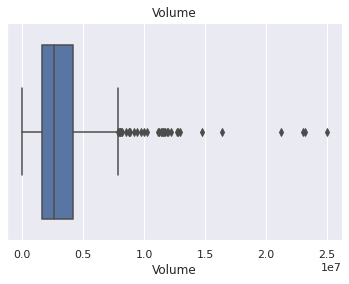

Number of outliers in Volume:


array([11688800,  8824000, 12657800, 21231800, 10012700, 11556300,
       16379700, 11426700,  9706300, 11991700,  9384300, 12975800,
       12765800, 12162400, 11388200,  7891600, 24977900, 23050400,
        8141500,  7884700, 11862400,  8118400, 11649800,  8001600,
        7994300, 14773700,  8723000,  8545000, 23219400,  8739800,
       10220800, 11174200,  9172400, 11164900])

34

None


In [ ]:
import seaborn as sns

for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    sns.boxplot(x=data_copy[col])
    plt.title(col)
    plt.show()
    
    print(f"Number of outliers in {col}:")
    outliers = count_outliers(data_copy, col)
    print(outliers)


Results:
*   65 outliers in Close
*   34 outliers in Volume



# Handling Outlier

In [ ]:
def remove_outlier(df, col):
    lb, ub = get_lower_upper_bound(df[col])
    df = df.drop(df[(df[col] > ub) | (df[col] < lb)].index)
    return df

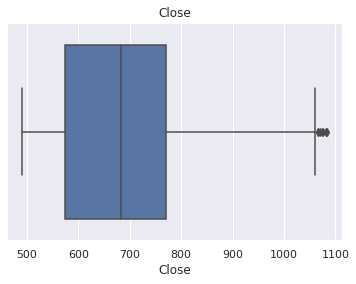

Number of outliers in Close:


array([1066.94, 1075.19, 1081.69, 1074.34, 1067.03, 1070.04, 1066.93,
       1081.78, 1083.25])

9

None


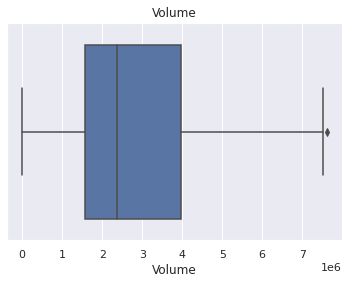

Number of outliers in Volume:


array([7613100])

1

None


In [ ]:
dfclean = data_copy.copy(deep=True)

for col in ['Close', 'Volume']:
    dfclean = remove_outlier(dfclean, col)

    sns.boxplot(x=dfclean[col])
    plt.title(col)
    plt.show()

    print(f"Number of outliers in {col}:")
    outliers = count_outliers(dfclean, col)
    print(outliers)

In [ ]:
dfclean.info()
dfclean.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1163 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1163 non-null   datetime64[ns]
 1   Open    1163 non-null   float64       
 2   High    1163 non-null   float64       
 3   Low     1163 non-null   float64       
 4   Close   1163 non-null   float64       
 5   Volume  1163 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 63.6 KB


,count,mean,std,min,25%,50%,75%,max
Open,1163.0,5.352107e+02,1.548683e+02,279.12,402.420,535.78,687.725,816.68
High,1163.0,5.394116e+02,1.560250e+02,281.21,406.165,539.27,697.280,816.68
Low,1163.0,5.305831e+02,1.533873e+02,277.22,400.750,531.35,680.465,805.14
Close,1163.0,6.873357e+02,1.302828e+02,491.20,572.620,682.40,769.590,1083.25
Volume,1163.0,2.852855e+06,1.575600e+06,7900.00,1576350.000,2370400.00,3965450.000,7613100.00


In [ ]:
dfclean

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500
1,2012-01-04,331.27,333.87,329.08,666.45,5749400
2,2012-01-05,329.83,330.75,326.89,657.21,6590300
3,2012-01-06,328.34,328.77,323.68,648.24,5405900
6,2012-01-11,310.59,313.52,309.40,624.25,4817800
...,...,...,...,...,...,...
1253,2016-12-23,790.90,792.74,787.28,789.91,623400
1254,2016-12-27,790.68,797.86,787.66,791.55,789100
1255,2016-12-28,793.70,794.23,783.20,785.05,1153800
1256,2016-12-29,783.33,785.93,778.92,782.79,744300


# Training and Validation Split
80% Training
20% Validation

In [ ]:
# Sort the dataframe by date
dfclean = dfclean.sort_values('Date')

# Calculate the index to split the dataframe into train and validation sets
split_idx = int(0.8 * len(dfclean))

# Split the dataframe into train and validation sets
dftrain = dfclean[:split_idx]
dfval = dfclean[split_idx:]

In [ ]:
print(dftrain)
print(dfval)

           Date    Open    High     Low   Close   Volume
0    2012-01-03  325.25  332.83  324.97  663.59  7380500
1    2012-01-04  331.27  333.87  329.08  666.45  5749400
2    2012-01-05  329.83  330.75  326.89  657.21  6590300
3    2012-01-06  328.34  328.77  323.68  648.24  5405900
6    2012-01-11  310.59  313.52  309.40  624.25  4817800
...         ...     ...     ...     ...     ...      ...
1020 2016-01-25  723.58  729.68  710.01  711.67  1711700
1021 2016-01-26  713.85  718.28  706.48  713.04  1331700
1022 2016-01-27  713.67  718.23  694.39  699.99  2194200
1023 2016-01-28  722.22  733.69  712.35  730.96  2676400
1024 2016-01-29  731.53  744.99  726.80  742.95  3474300

[930 rows x 6 columns]
           Date    Open    High     Low   Close   Volume
1025 2016-02-01  750.46  757.86  743.27  752.00  5139200
1026 2016-02-02  784.50  789.87  764.65  764.65  6348100
1027 2016-02-03  770.22  774.50  720.50  726.95  6171000
1028 2016-02-04  722.81  727.00  701.86  708.01  5168700
1029 20

# Scaling Data

In [ ]:
def preprocess_data(data, prediction_days):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    # Prepare the data for training
    x_data = []
    y_data = []
    for x in range(prediction_days, len(scaled_data)):
        x_data.append(scaled_data[x - prediction_days : x, 0])
        y_data.append(scaled_data[x, 0])

    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

    return x_data, y_data, scaler

In [ ]:
# Use 60 days as the basis to predicting the next 1 day
prediction_days = 60

# Preprocess the training data
x_train, y_train, scaler_train = preprocess_data(dftrain["Close"], prediction_days)

# Preprocess the validation data
x_val, y_val, scaler_val = preprocess_data(dfval["Close"], prediction_days)

# LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss",
                               mode = 'auto',
                               patience=15)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=300, batch_size=25, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/300
35/35 [==============================] - 30s 351ms/step - loss: 0.0364 - val_loss: 0.0391
Epoch 2/300
35/35 [==============================] - 7s 198ms/step - loss: 0.0125 - val_loss: 0.0229
Epoch 3/300
35/35 [==============================] - 4s 109ms/step - loss: 0.0098 - val_loss: 0.0299
Epoch 4/300
35/35 [==============================] - 3s 94ms/step - loss: 0.0097 - val_loss: 0.0177
Epoch 5/300
35/35 [==============================] - 3s 94ms/step - loss: 0.0085 - val_loss: 0.0151
Epoch 6/300
35/35 [==============================] - 5s 144ms/step - loss: 0.0078 - val_loss: 0.0141
Epoch 7/300
35/35 [==============================] - 3s 98ms/step - loss: 0.0069 - val_loss: 0.0162
Epoch 8/300
35/35 [==============================] - 3s 94ms/step - loss: 0.0072 - val_loss: 0.0204
Epoch 9/300
35/35 [==============================] - 3s 95ms/step - loss: 0.0061 - val_loss: 0.0119
Epoch 10/300
35/35 [==============================] - 5s 155ms/step - loss: 0.0060 - val_loss: 

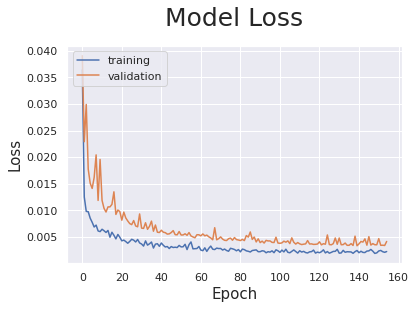

In [ ]:
# Plotting Loss along Epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['training', 'validation'], loc='upper left')

# Testing LSTM


In [ ]:
dftest = load_data('/content/Google_Stock_Price_Test.csv')

# Show the first 5 rows of dataset
dftest.head()

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,1657300
1,2017-01-04,788.36,791.34,783.16,786.90,1073000
2,2017-01-05,786.08,794.48,785.02,794.02,1335200
3,2017-01-06,795.26,807.90,792.20,806.15,1640200
4,2017-01-09,806.40,809.97,802.83,806.65,1272400


In [ ]:
actual_prices = dftest['Close'].values
total_dataset = pd.concat((dfclean['Close'], dftest['Close']), axis=0)

In [ ]:
model_inputs = total_dataset[len(total_dataset) - len(dftest) - prediction_days:].values

In [ ]:
def preprocess_test_data(data, prediction_days):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    # Prepare the data for testing
    x_data = []
    for x in range(prediction_days, len(scaled_data)):
        x_data.append(scaled_data[x - prediction_days : x, 0])

    x_data = np.array(x_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

    return x_data, scaler

In [ ]:
x_test, scaler_test = preprocess_test_data(model_inputs, prediction_days)

In [ ]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler_test.inverse_transform(predicted_prices)

1/1 [==============================] - 2s 2s/step


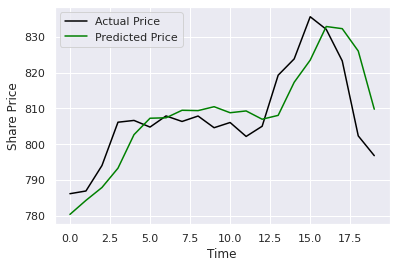

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_prices, color='green', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Share Price')
plt.legend()
plt.show()

In [ ]:
# Combine actual_prices, predicted_prices, and date into a single dataframe
result_df = pd.DataFrame({'Date': dftest['Date'], 'Actual Prices': actual_prices, 'Predicted Prices': predicted_prices.reshape(-1)})
result_df = result_df.set_index('Date')

result_df

,Actual Prices,Predicted Prices
Date,,
2017-01-03,786.14,780.343811
2017-01-04,786.90,784.270264
2017-01-05,794.02,787.877258
2017-01-06,806.15,793.285767
2017-01-09,806.65,802.664978
2017-01-10,804.79,807.262756
2017-01-11,807.91,807.390503
2017-01-12,806.36,809.490723
2017-01-13,807.88,809.395569


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# Print evaluation metrics
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Mean Absolute Error (MAE): ", mae)
print("R-squared (R2): ", r2)
print("Mean Absolute Percentage Error (MAPE): ", mape)

Mean Squared Error (MSE):  75.33878471636606
Root Mean Squared Error (RMSE):  8.679791743836143
Mean Absolute Error (MAE):  6.663276977539056
R-squared (R2):  0.5455526440725681
Mean Absolute Percentage Error (MAPE):  1.8445503326363637


The results are quite close, but they seem to be late one day. Let's try to shift them to get a better look.

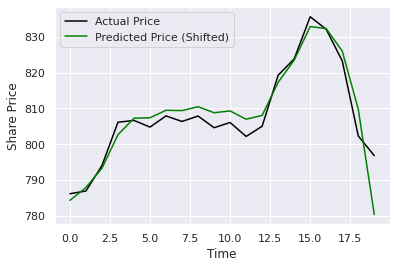

In [ ]:
# Shift the predicted prices by one day
predicted_prices_shifted = np.roll(predicted_prices, -1)

plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_prices_shifted, color='green', label='Predicted Price (Shifted)')
plt.xlabel('Time')
plt.ylabel('Share Price')
plt.legend()
plt.show()

In [ ]:
# Combine actual_prices, predicted_prices_shifted, and date into a single dataframe
result_df = pd.DataFrame({'Date': dftest['Date'], 'Actual Prices': actual_prices, 'Predicted Prices': predicted_prices_shifted.reshape(-1)})
result_df = result_df.set_index('Date')

result_df

,Actual Prices,Predicted Prices
Date,,
2017-01-03,786.14,784.270264
2017-01-04,786.90,787.877258
2017-01-05,794.02,793.285767
2017-01-06,806.15,802.664978
2017-01-09,806.65,807.262756
2017-01-10,804.79,807.390503
2017-01-11,807.91,809.490723
2017-01-12,806.36,809.395569
2017-01-13,807.88,810.491699


In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices_shifted)
mae = mean_absolute_error(actual_prices, predicted_prices_shifted)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices_shifted)
mape = np.mean(np.abs((actual_prices - predicted_prices_shifted) / actual_prices)) * 100

# Print evaluation metrics
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Mean Absolute Error (MAE): ", mae)
print("R-squared (R2): ", r2)
print("Mean Absolute Percentage Error (MAPE): ", mape)

Mean Squared Error (MSE):  22.44158281206926
Root Mean Squared Error (RMSE):  4.737254775929753
Mean Absolute Error (MAE):  3.2360963134765597
R-squared (R2):  0.8646312386088181
Mean Absolute Percentage Error (MAPE):  1.8445503326363637


# **RNN**

## Importing Libraries

In [ ]:
# Library RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

## Building Model

In [ ]:
modelr = Sequential()
#RNN Layer 1
modelr.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (x_train.shape[1],1)))
modelr.add(Dropout(0.2))
#RNN Layer 2
modelr.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
modelr.add(Dropout(0.2))
#RNN Layer 3
modelr.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
modelr.add(Dropout(0.2))
#RNN Layer 4
modelr.add(SimpleRNN(units = 50))
modelr.add(Dropout(0.2))
#RNN Output
modelr.add(Dense(units=1))

## Training RNN Model

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss",
                               mode = 'auto',
                               patience=15)

# Compiling
modelr.compile(optimizer='adam', loss='mean_squared_error')

# RNN Fitting
history = modelr.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
28/28 [==============================] - 7s 93ms/step - loss: 0.4189 - val_loss: 0.0183
Epoch 2/50
28/28 [==============================] - 2s 69ms/step - loss: 0.2646 - val_loss: 0.0140
Epoch 3/50
28/28 [==============================] - 2s 87ms/step - loss: 0.2065 - val_loss: 0.0129
Epoch 4/50
28/28 [==============================] - 4s 128ms/step - loss: 0.1612 - val_loss: 0.0173
Epoch 5/50
28/28 [==============================] - 2s 69ms/step - loss: 0.1586 - val_loss: 0.0118
Epoch 6/50
28/28 [==============================] - 2s 69ms/step - loss: 0.1147 - val_loss: 0.0143
Epoch 7/50
28/28 [==============================] - 2s 69ms/step - loss: 0.1015 - val_loss: 0.0430
Epoch 8/50
28/28 [==============================] - 2s 70ms/step - loss: 0.0769 - val_loss: 0.0118
Epoch 9/50
28/28 [==============================] - 2s 69ms/step - loss: 0.0684 - val_loss: 0.0090
Epoch 10/50
28/28 [==============================] - 3s 118ms/step - loss: 0.0576 - val_loss: 0.0323
Epoch 1

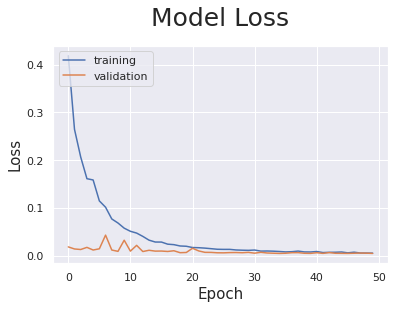

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['training', 'validation'], loc='upper left')

## Testing RNN

In [ ]:
predicted_pricesRNN = modelr.predict(x_test)
predicted_pricesRNN = scaler_test.inverse_transform(predicted_pricesRNN)

1/1 [==============================] - 0s 497ms/step


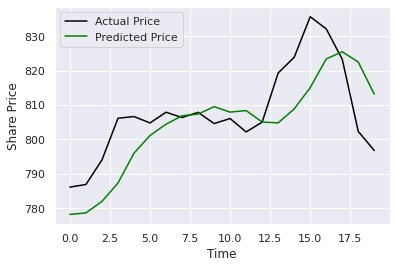

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_pricesRNN, color='green', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Share Price')
plt.legend()
plt.show()

In [ ]:
# Combine actual_prices, predicted_prices, and date into a single dataframe
result_df = pd.DataFrame({'Date': dftest['Date'], 'Actual Prices': actual_prices, 'Predicted Prices': predicted_pricesRNN.reshape(-1)})
result_df = result_df.set_index('Date')

result_df

,Actual Prices,Predicted Prices
Date,,
2017-01-03,786.14,778.192566
2017-01-04,786.90,778.627686
2017-01-05,794.02,781.973694
2017-01-06,806.15,787.315369
2017-01-09,806.65,796.008301
2017-01-10,804.79,801.141052
2017-01-11,807.91,804.433594
2017-01-12,806.36,806.877258
2017-01-13,807.88,807.358215


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_pricesRNN)
mae = mean_absolute_error(actual_prices, predicted_pricesRNN)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_pricesRNN)
mape = np.mean(np.abs((actual_prices - predicted_pricesRNN) / actual_prices)) * 100

# Print evaluation metrics
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Mean Absolute Error (MAE): ", mae)
print("R-squared (R2): ", r2)
print("Mean Absolute Percentage Error (MAPE): ", mape)

Mean Squared Error (MSE):  122.68180943664727
Root Mean Squared Error (RMSE):  11.0761820785254
Mean Absolute Error (MAE):  8.827009155273425
R-squared (R2):  0.2599771269370349
Mean Absolute Percentage Error (MAPE):  1.8211135439198702


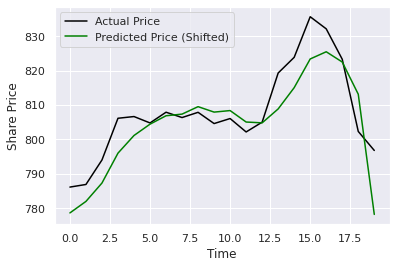

In [ ]:
# Shift the predicted prices by one day
predicted_prices_shiftedRNN = np.roll(predicted_pricesRNN, -1)

plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_prices_shiftedRNN, color='green', label='Predicted Price (Shifted)')
plt.xlabel('Time')
plt.ylabel('Share Price')
plt.legend()
plt.show()

In [ ]:
# Combine actual_prices, predicted_prices_shiftedRNN, and date into a single dataframe
result_df = pd.DataFrame({'Date': dftest['Date'], 'Actual Prices': actual_prices, 'Predicted Prices': predicted_prices_shiftedRNN.reshape(-1)})
result_df = result_df.set_index('Date')

result_df

,Actual Prices,Predicted Prices
Date,,
2017-01-03,786.14,778.627686
2017-01-04,786.90,781.973694
2017-01-05,794.02,787.315369
2017-01-06,806.15,796.008301
2017-01-09,806.65,801.141052
2017-01-10,804.79,804.433594
2017-01-11,807.91,806.877258
2017-01-12,806.36,807.358215
2017-01-13,807.88,809.525269


In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices_shiftedRNN)
mae = mean_absolute_error(actual_prices, predicted_prices_shiftedRNN)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices_shiftedRNN)
mape = np.mean(np.abs((actual_prices - predicted_prices_shiftedRNN) / actual_prices)) * 100

# Print evaluation metrics
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Mean Absolute Error (MAE): ", mae)
print("R-squared (R2): ", r2)
print("Mean Absolute Percentage Error (MAPE): ", mape)

Mean Squared Error (MSE):  56.70903337463555
Root Mean Squared Error (RMSE):  7.530540045351034
Mean Absolute Error (MAE):  5.799690795898414
R-squared (R2):  0.6579282454405553
Mean Absolute Percentage Error (MAPE):  1.8211135439198705


# References
https://www.youtube.com/watch?v=PuZY9q-aKLw